# Importing Libraries

In [59]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

# Reading and preparing data

According to what we decided during previous stages, we will remove columns with high correlation, remove outliers (with automatic detection) and use box cox and standard scaler on our data.

In [33]:
df_train=pd.read_csv('../data/for_modelling/credit_score_train.csv')
df_val=pd.read_csv('../data/for_modelling/credit_score_valid.csv')
df = pd.concat([df_train, df_val])
df

INCOME  SAVINGS     DEBT  R_SAVINGS_INCOME  R_DEBT_INCOME  \
0      2783     1855        0            0.6665         0.0000   
1    314430   445442   707468            1.4167         2.2500   
2    161773   517674  2782496            3.2000        17.2000   
3     16014    97685    20818            6.1000         1.3000   
4    193225  1410542  2589215            7.3000        13.4000   
..      ...      ...      ...               ...            ...   
133  386976  1250231   654883            3.2308         1.6923   
134   16772     8386        0            0.5000         0.0000   
135  137509   206264   206264            1.5000         1.5000   
136  259146  1922000  1662854            7.4167         6.4167   
137   56657   442952    51506            7.8181         0.9091   

     R_DEBT_SAVINGS  T_CLOTHING_12  T_CLOTHING_6  R_CLOTHING  \
0            0.0000            103            74      0.7184   
1            1.5882          35861         29157      0.8131   
2            5.3750           3716          2533      0.6816   
3            0.2131            637           187      0.2936   
4            1.8356           5276          2325      0.4407   
..              ...            ...           ...         ...   
133          0.5238          36665         30569      0.8337   
134          0.0000            238           186      0.7815   
135          1.0000          15661         10865      0.6938   
136          0.8652          12180          8527      0.7001   
137          0.1163           1085           289      0.2664   

     R_CLOTHING_INCOME  ...  R_EXPENDITURE_SAVINGS  R_EXPENDITURE_DEBT  \
0               0.0370  ...                 2.5003              0.0000   
1               0.1141  ...                 0.5882              0.3704   
2               0.0230  ...                 0.3125              0.0581   
3               0.0398  ...                 0.1639              0.7692   
4               0.0273  ...                 0.1370              0.0746   
..                 ...  ...                    ...                 ...   
133             0.0947  ...                 0.2381              0.4545   
134             0.0142  ...                 2.5000              0.9786   
135             0.1139  ...                 0.6667              0.6667   
136             0.0470  ...                 0.1124              0.1299   
137             0.0192  ...                 0.1163              1.0000   

     CAT_GAMBLING  CAT_DEBT  CAT_CREDIT_CARD  CAT_MORTGAGE  \
0              No         0                0             0   
1            High         1                0             1   
2              No         1                1             1   
3              No         1                0             0   
4              No         1                1             0   
..            ...       ...              ...           ...   
133            No         1                0             0   
134            No         0                0             0   
135            No         1                0             0   
136          High         1                1             0   
137            No         1                0             0   

     CAT_SAVINGS_ACCOUNT  CAT_DEPENDENTS  CREDIT_SCORE  DEFAULT  
0                      1               0           570        0  
1                      1               0           691        0  
2                      1               1           520        0  
3                      1               0           654        0  
4                      1               1           552        0  
..                   ...             ...           ...      ...  
133                    1               0           562        0  
134                    1               0           619        0  
135                    1               0           639        1  
136                    1               1           587        1  
137                    1               0           635        1  

[628 rows x 86 c

### setting target

In [34]:
target = 'DEFAULT'

### removing columns and mapping

In [35]:
# columns to remove from EDA
columns_to_remove = ["T_CLOTHING_12","T_ENTERTAINMENT_12", "T_GROCERIES_12", "T_GROCERIES_6", "T_HEALTH_12", "T_TAX_12", "T_TAX_6", "T_TRAVEL_12", "T_TRAVEL_6","T_UTILITIES_12", "T_UTILITIES_6", "T_EXPENDITURE_12", "T_EXPENDITURE_6"]
# remove columns with high correlation
df_train.drop(columns=columns_to_remove, inplace=True)
df_val.drop(columns=columns_to_remove, inplace=True)

# map CAT_GAMBLING (No-0, Low-1, High-2)
df_train['CAT_GAMBLING'] = df_train['CAT_GAMBLING'].map({'No':0, 'Low':1, 'High':2})
df_val['CAT_GAMBLING'] = df_val['CAT_GAMBLING'].map({'No':0, 'Low':1, 'High':2})

### removing outliers

In [36]:
from pyod.models.knn import KNN
clf = KNN(contamination=0.04)
rest_cols = [col for col in df_train.columns if col not in columns_to_remove]
# remove DEFAULT column
rest_cols.remove('DEFAULT')
clf.fit(df_train[rest_cols])
df_train['outliers'] = clf.labels_
# sum of outliers
df_train['outliers'].value_counts()

0    470
1     20
Name: outliers, dtype: int64

In [37]:
df_train = df_train[df_train['outliers'] == 0]
df_train.drop(columns='outliers', inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train

INCOME  SAVINGS     DEBT  R_SAVINGS_INCOME  R_DEBT_INCOME  \
0      2783     1855        0            0.6665         0.0000   
1    314430   445442   707468            1.4167         2.2500   
2    161773   517674  2782496            3.2000        17.2000   
3     16014    97685    20818            6.1000         1.3000   
4    193225  1410542  2589215            7.3000        13.4000   
..      ...      ...      ...               ...            ...   
465   20007    22508   457665            1.1250        22.8752   
466   20846   268679    23162           12.8888         1.1111   
467   89235  1106514   160623           12.4000         1.8000   
468  197073  1021195  1863233            5.1818         9.4545   
469  133592    85013   680103            0.6364         5.0909   

     R_DEBT_SAVINGS  T_CLOTHING_6  R_CLOTHING  R_CLOTHING_INCOME  \
0            0.0000            74      0.7184             0.0370   
1            1.5882         29157      0.8131             0.1141   
2            5.3750          2533      0.6816             0.0230   
3            0.2131           187      0.2936             0.0398   
4            1.8356          2325      0.4407             0.0273   
..              ...           ...         ...                ...   
465         20.3334           861      0.5934             0.0725   
466          0.0862           533      0.4094             0.0625   
467          0.1452           835      0.3460             0.0270   
468          1.8246          3948      0.4691             0.0427   
469          8.0000           264      0.0212             0.0934   

     R_CLOTHING_SAVINGS  ...  R_EXPENDITURE_SAVINGS  R_EXPENDITURE_DEBT  \
0                0.0555  ...                 2.5003              0.0000   
1                0.0805  ...                 0.5882              0.3704   
2                0.0072  ...                 0.3125              0.0581   
3                0.0065  ...                 0.1639              0.7692   
4                0.0037  ...                 0.1370              0.0746   
..                  ...  ...                    ...                 ...   
465              0.0645  ...                 1.1111              0.0546   
466              0.0048  ...                 0.0862              1.0000   
467              0.0022  ...                 0.0806              0.5556   
468              0.0082  ...                 0.1754              0.0962   
469              0.1468  ...                 1.4286              0.1786   

     CAT_GAMBLING  CAT_DEBT  CAT_CREDIT_CARD  CAT_MORTGAGE  \
0               0         0                0             0   
1               2         1                0             1   
2               0         1                1             1   
3               0         1                0             0   
4               0         1                1             0   
..            ...       ...              ...           ...   
465             0         1                0             0   
466             1         1                0             0   
467             0         1                0             0   
468             2         1                0             1   
469             2         1                0             0   

     CAT_SAVINGS_ACCOUNT  CAT_DEPENDENTS  CREDIT_SCORE  DEFAULT  
0                      1               0           570        0  
1                      1               0           691        0  
2                      1               1           520        0  
3                      1               0           654        0  
4                      1               1           552        0  
..                   ...             ...           ...      ...  
465                    1               0           423        0  
466                    1               0           584        0  
467                    1               0           631        0  
468                    1               1           572        0  
469                    

### using box cox and standard scaler

In [38]:
# using box cox and standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import boxcox

X=df_train.drop(target, axis=1)
y=df_train[target]
X=X[rest_cols]
X_val=df_val.drop(target, axis=1)
y_val=df_val[target]
X_val=X_val[rest_cols]

# Box Cox and standart scalling
cox_box_model = PowerTransformer(method='yeo-johnson')
X = cox_box_model.fit_transform(X)
X_val = cox_box_model.transform(X_val)
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)

# Data is ready :))

# Explainable AI

We will be doing it on those models from previous part, which we found the best.
It will be:
- XGBoost
- Naive Bayes
- TPOT
- soft voting

## 1. XGBoost

In [39]:
# !pip install xgboost
from xgboost import XGBClassifier
model_xgboost=XGBClassifier(random_state=1,
                            learning_rate=0.01,
                            booster='gbtree',
                            max_depth=4
                            )
model_xgboost.fit(X, y)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

### 1.1 SHAP

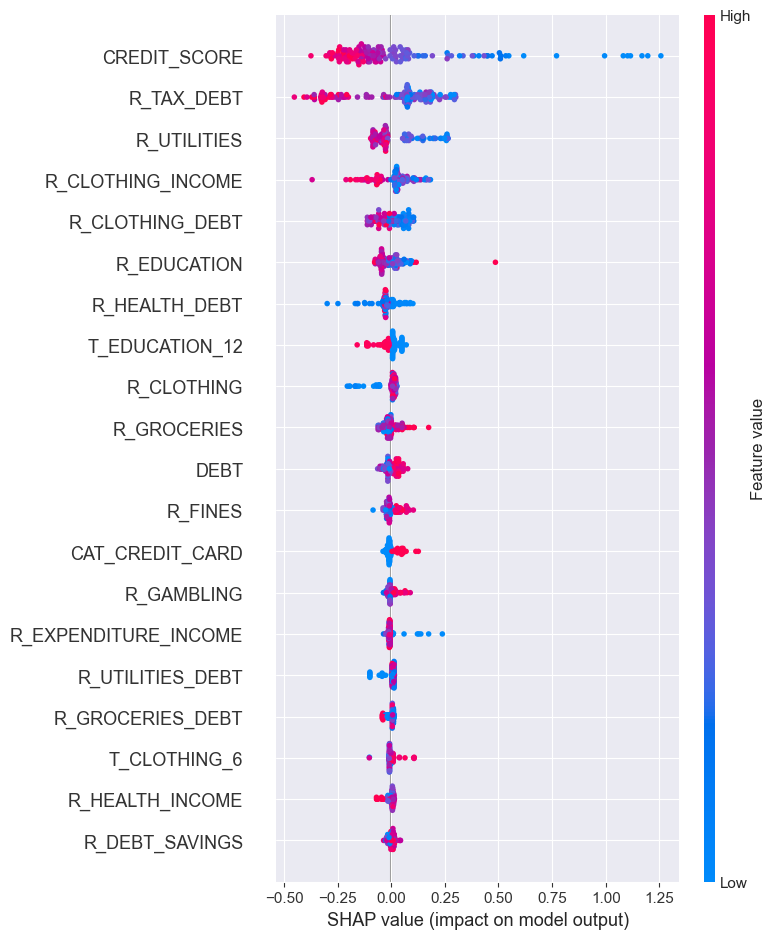

In [47]:
# !pip install shap
import shap
explainer_shap_xgboost = shap.TreeExplainer(model_xgboost)
shap_values_xgboost = explainer_shap_xgboost.shap_values(X_val)
#visualizing SHAP
shap.summary_plot(shap_values_xgboost, X_val, rest_cols)

Conslusions and explanations:
- features are listed from top to bottom based on their impact on the model output. The most important features have the greatest influence on model predictions. We can see CREDIT_SCORE is the most important and it would seem resonable.
- the color represents the feature value (red high, blue low). For example, we can see that the higher the CREDIT_SCORE, the lower the probability of default.
- the horizontal spread of the dots shows the distribution of the feature impact on the model. A wider spread means the impact of that feature on the predictions varies more among different observations.

### 1.2 Partial Dependence Plot

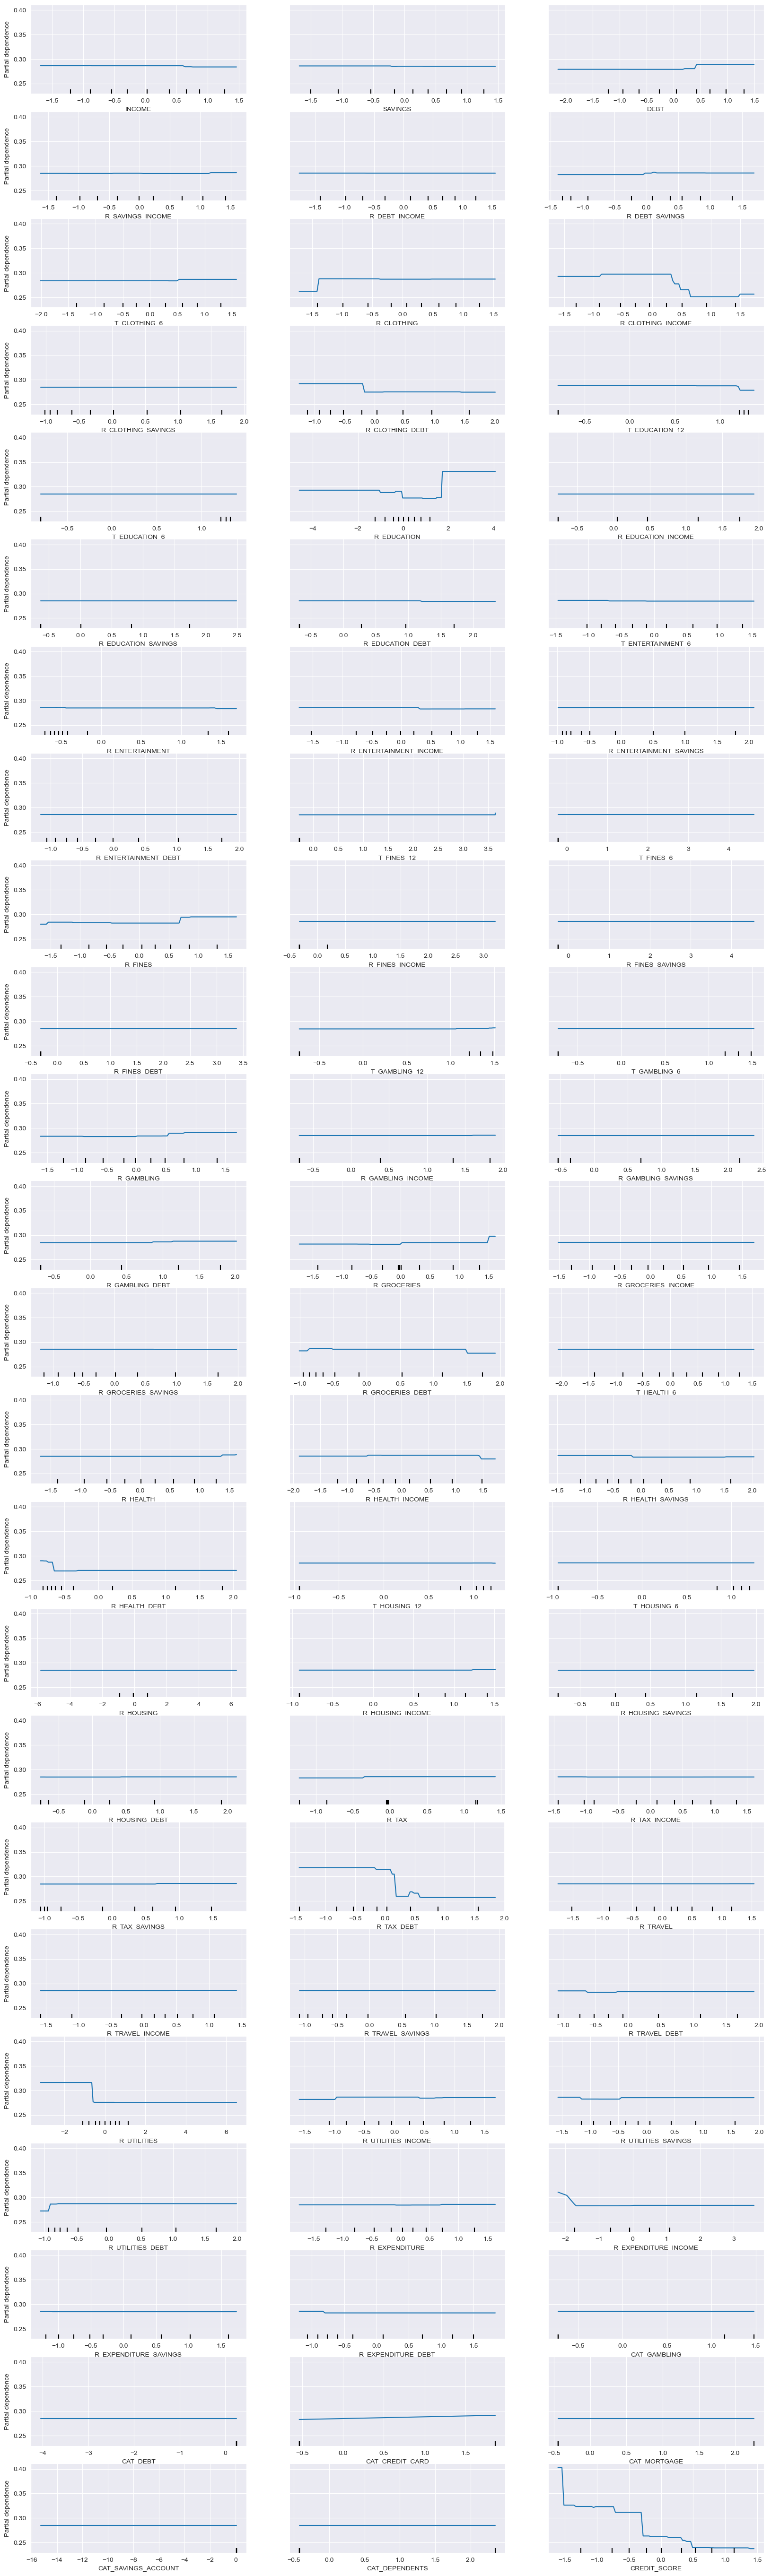

In [62]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(20, 70))
PartialDependenceDisplay.from_estimator(model_xgboost, X, features=list(range(72)), feature_names=rest_cols, ax=ax)

Conslusions:
- the most important feature is CREDIT_SCORE, which is consistent with SHAP (SHAP and PDP showed that the higher the CREDIT_SCORE, the lower the probability of default).
- there are many features that have a marginal impact on the model output and only few with bigger impact (like R_EDUCATION nad R_CLOTHING_INCOME, but these still isn't big impact on the model olutput).

## 2. Naive Bayes

In [52]:
# installing and setting up naive bayes
# !pip install xgboost
from sklearn.naive_bayes import GaussianNB
model_naive_bayes = GaussianNB(var_smoothing=1e-05)
model_naive_bayes.fit(X, y)

GaussianNB(var_smoothing=1e-05)

### 2.1 SHAP
we won't use it here because Naive Bayes isn't compatible with SHAP

### 2.2 LIME

In [38]:
#!pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ----- ------------------------------- 41.0/275.7 kB 991.0 kB/s eta 0:00:01
     ------------------- ------------------ 143.4/275.7 kB 1.7 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283846 sha256=045b62ae7d574a1d258f3dc8f0592cbaad3fc879860383cd1219a3f2a937026f
  Stored in directory: c:\users\domin\appdata\local\pip\cache\wheels\85\fa\a3\9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [91]:
import lime
import lime.lime_tabular
explainer_lime_naive_bayes = lime.lime_tabular.LimeTabularExplainer(X, feature_names=rest_cols, class_names=['DEFAULT'], discretize_continuous=True)
exp = explainer_lime_naive_bayes.explain_instance(X_val[0], model_naive_bayes.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)

In [92]:
exp = explainer_lime_naive_bayes.explain_instance(X_val[1], model_naive_bayes.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)

Conslusions and explanations:

### 2.3 Partial Dependence Plot

In [14]:
#!pip install -U scikit-learn

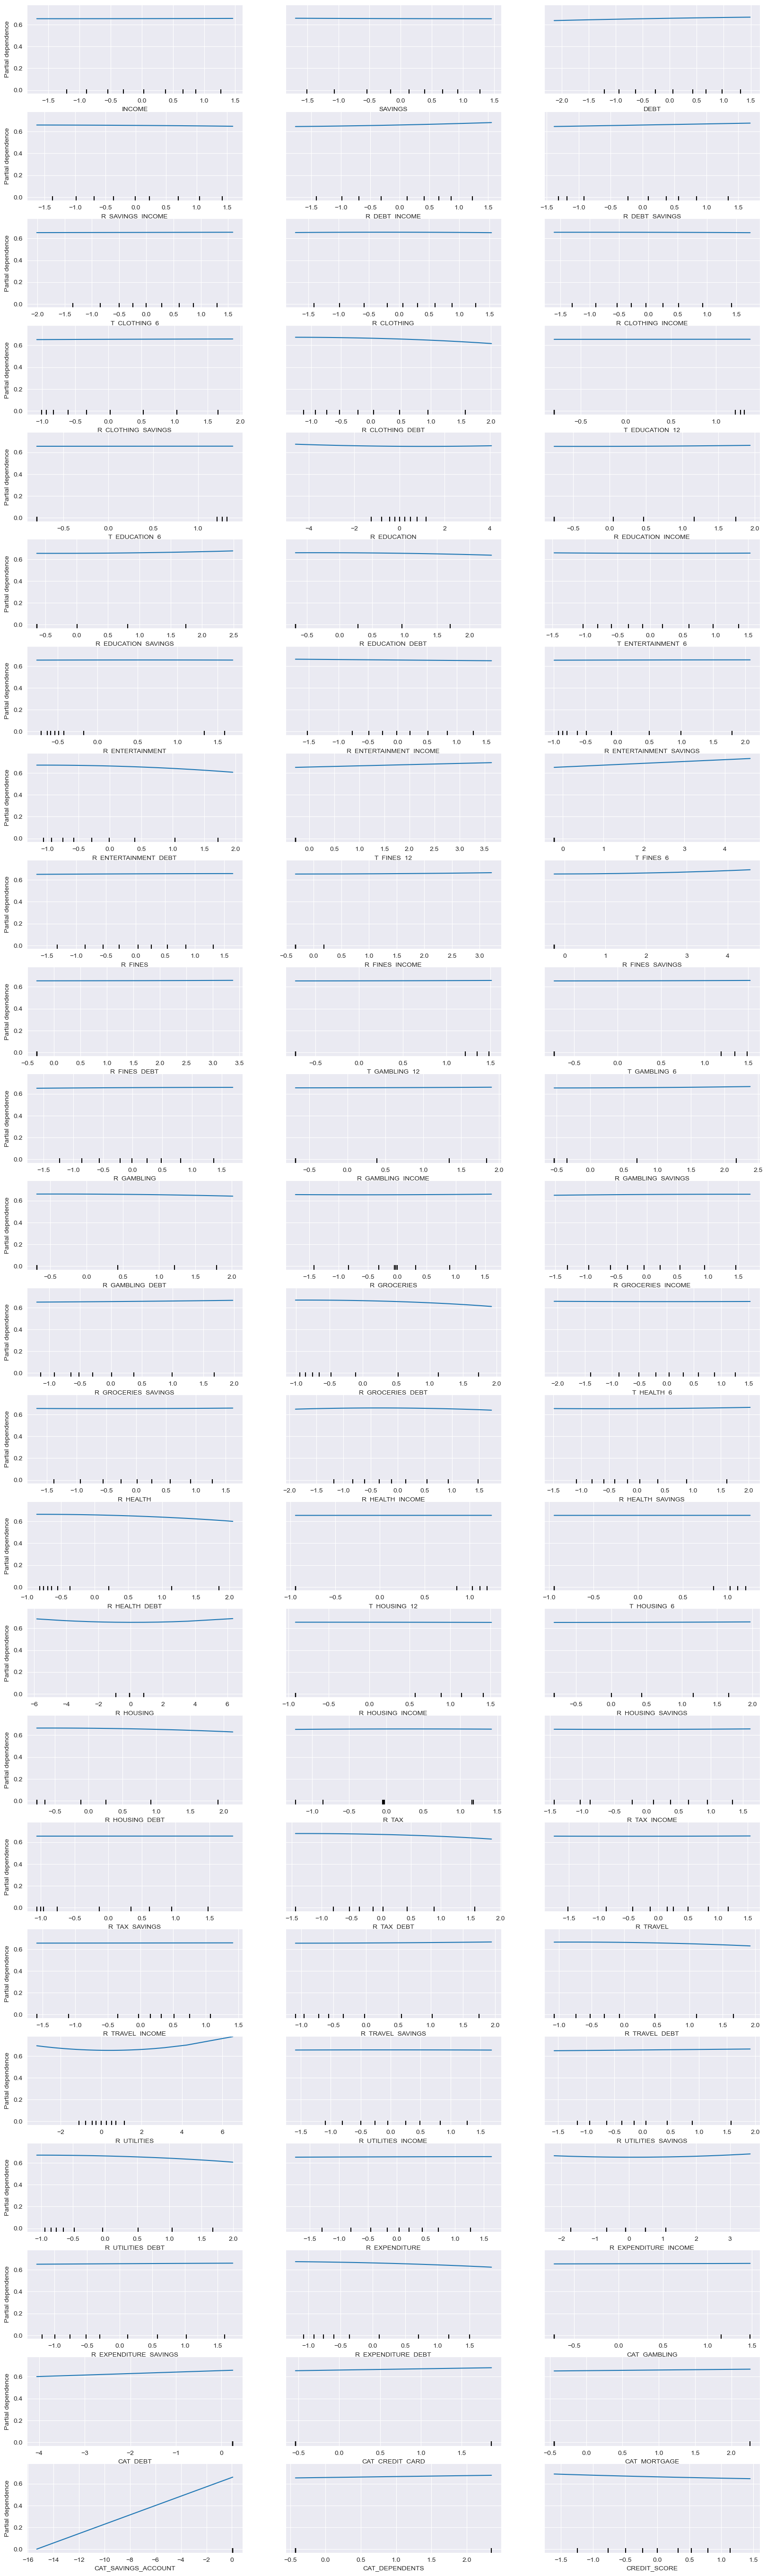

In [64]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(20, 70))
PartialDependenceDisplay.from_estimator(model_naive_bayes, X, features=list(range(72)), feature_names=rest_cols, ax=ax)

Conslusions:
- there are more linaer relationships between features and the model output than in the case of XGBoost.
- there are a lot of features (most of them) that have a marginal impact on the model output, only few has like any noticeable impact
- on the contrary to XGBoost, the most important feature is not CREDIT_SCORE, but CAT_SAVINGS_ACCOUNT.

## 3. TPOT

In [65]:
#!pip install tpot

In [71]:
from tpot import TPOTClassifier
model_tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
model_tpot.fit(X, y)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7404255319148936

Generation 2 - Current best internal CV score: 0.7404255319148936


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.5, min_samples_leaf=8, min_samples_split=9, n_estimators=100)


TPOTClassifier(generations=5, population_size=50, random_state=42, verbosity=2)

### 3.1 SHAP
we won't use it here because TPOT may generate pipelines with preprocessing steps and models that aren't directly compatible with SHAP's model-specific explainers.

### 3.2 Partial Dependence Plot

In [80]:
#!pip install -U scikit-learn

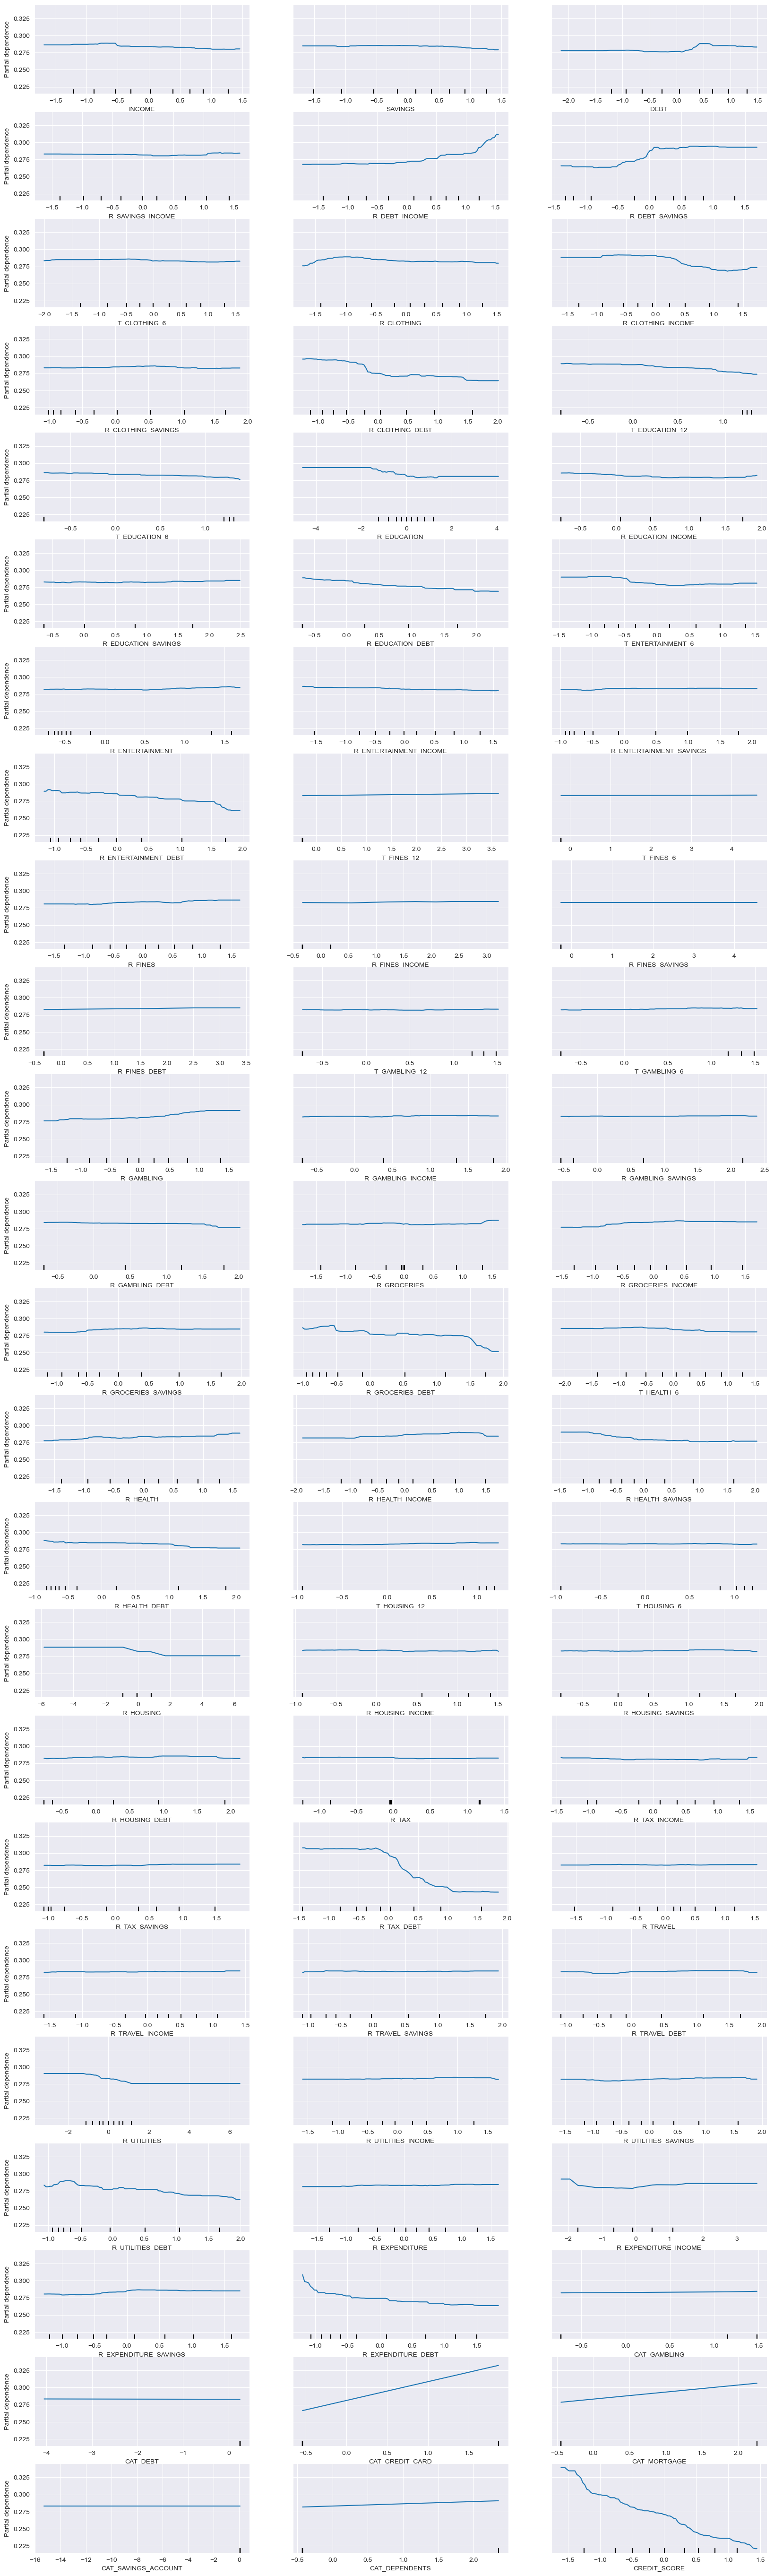

In [82]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(20, 70))
PartialDependenceDisplay.from_estimator(model_tpot, X, features=list(range(72)), feature_names=rest_cols, ax=ax)

Conslusions:
- there aren't many linear relationships between features and the model output (and for sure less than in the case of Naive Bayes)
- there aren't a lot of features that have a marginal impact on the model output - most of them have some impact (bigger or smaller)
- (once again) the most important feature is CREDIT_SCORE, which is consistent with XGBoost (but not with Naive Bayes), some of other important features are: CAT_CREDIT_CARD and mostly all of R_(name of category)_DEBT
- interestingly, CAT_SAVINGS_ACCOUNT, which was the most important in Naive Bayes, here has marginal impact

## 4. Soft Voting

In [84]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#defining models
model1 = DecisionTreeClassifier(random_state=1)
model2 = KNeighborsClassifier()
model3 = LogisticRegression(random_state=1, max_iter=1000)
model5 = RandomForestClassifier(random_state=1)
model6 = GradientBoostingClassifier(random_state=1)
model8 = GaussianNB()

estimators=[('DecisionTree', model1), ('KNN', model2), ('LR', model3),  ('RandomForest', model5),
            ('GradientBoosting', model6),
            ('NaiveBayes', model8)]

#defining voting classifier
model_voting = VotingClassifier(estimators=estimators, voting='soft', weights=[0.1, 0.1, 0.3, 0.3, 0.1,0.2])
model_voting.fit(X, y)

VotingClassifier(estimators=[('DecisionTree',
                              DecisionTreeClassifier(random_state=1)),
                             ('KNN', KNeighborsClassifier()),
                             ('LR',
                              LogisticRegression(max_iter=1000,
                                                 random_state=1)),
                             ('RandomForest',
                              RandomForestClassifier(random_state=1)),
                             ('GradientBoosting',
                              GradientBoostingClassifier(random_state=1)),
                             ('NaiveBayes', GaussianNB())],
                 voting='soft', weights=[0.1, 0.1, 0.3, 0.3, 0.1, 0.2])

### 4.1 SHAP
it takes too long to execute

In [85]:
# !pip install shap

In [87]:
# import shap
# explainer_shap_voting = shap.KernelExplainer(model_voting.predict_proba, X)
# shap_values_voting = explainer_shap_voting.shap_values(X_val)
#visualizing SHAP
# shap.summary_plot(shap_values_voting, X_val, rest_cols)

Using 470 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/138 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 4.2 Partial Dependence Plot
Be aware that it takes a lot of time to execute

In [88]:
#!pip install -U scikit-learn

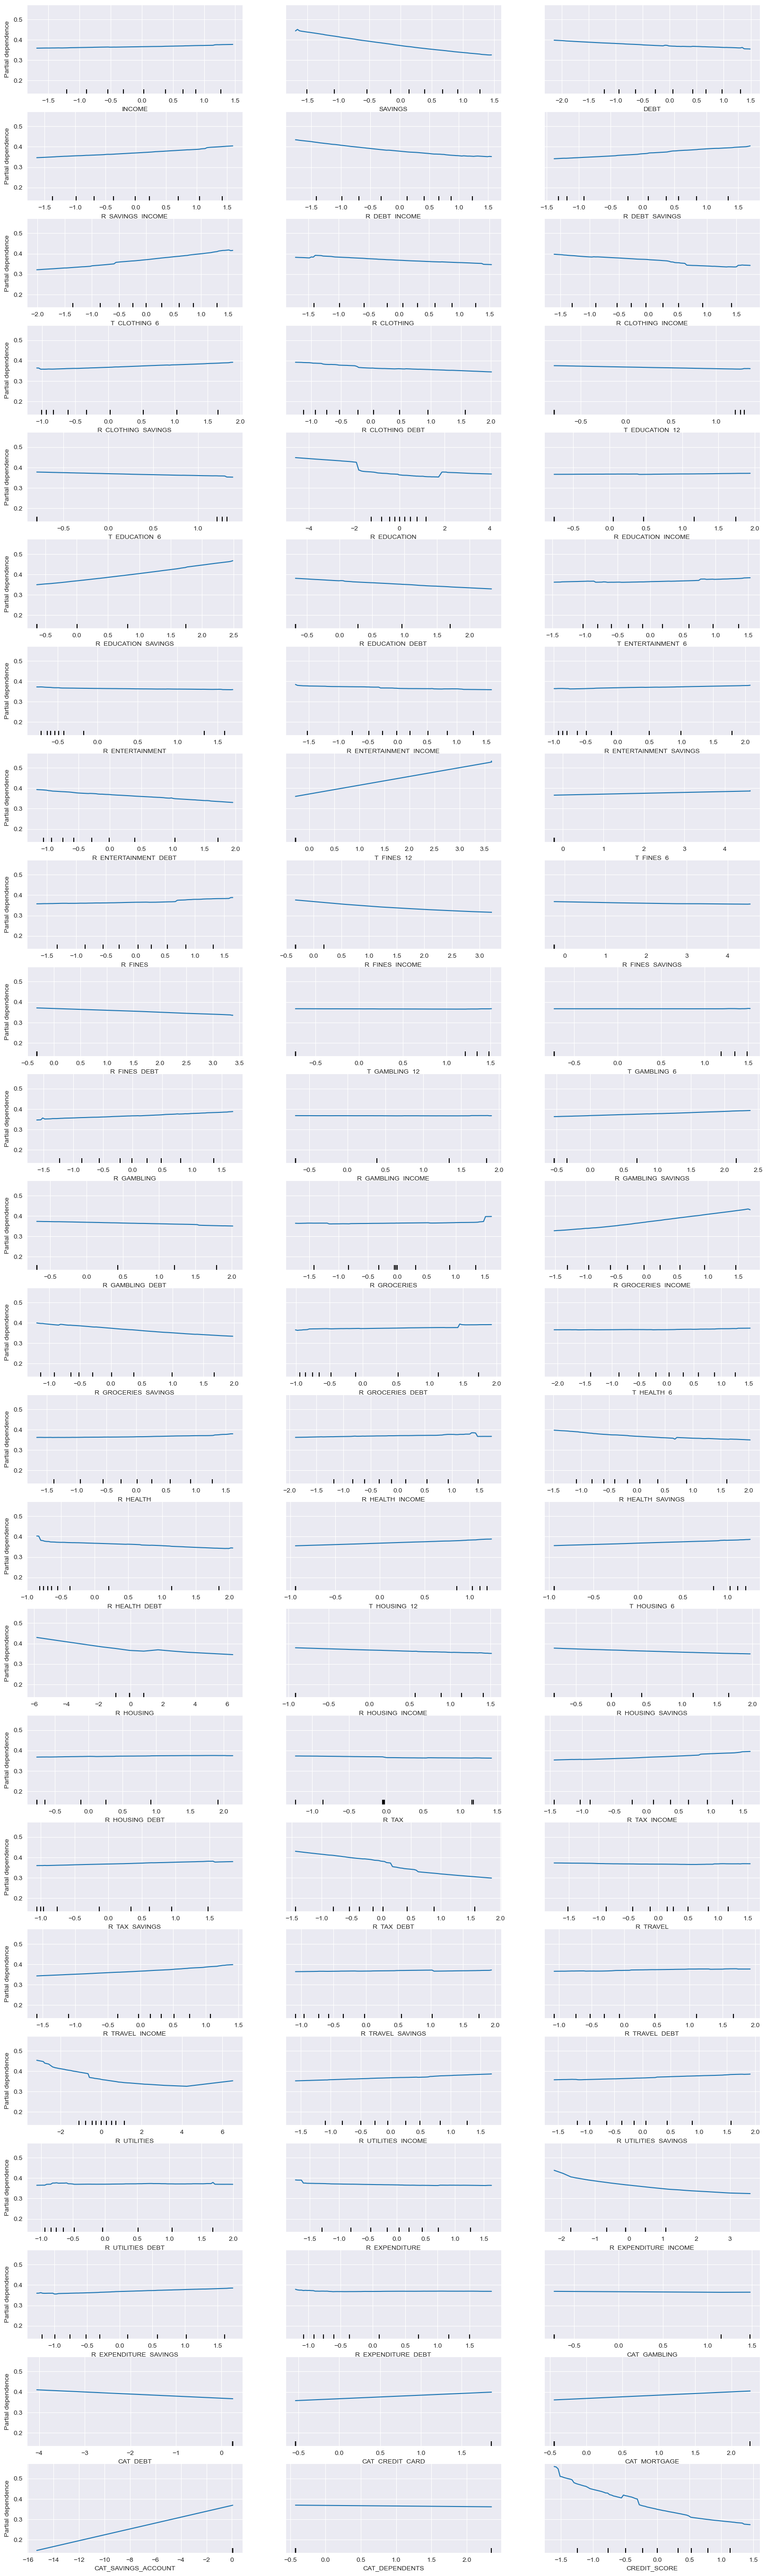

In [90]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(20, 70))
PartialDependenceDisplay.from_estimator(model_voting, X, features=list(range(72)), feature_names=rest_cols, ax=ax)

Conslusions:
- there are both linear and non-linear relationships between features and the model output
- there are not many features that have a marginal impact on the model output - most of them have some impact (bigger or smaller)
- one of the most important feature is CREDIT_SCORE, which is consistent with XGBoost. However, there are a few other features that are also important, like CAT_SAVINGS_ACCOUNT (which was the most important in Naive Bayes), T_FINES_12 or SAVINGS.